In [2]:
#PPO-LSTM
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import time
import numpy as np
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt


#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 2
T_horizon     = 20

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
        self.fc1   = nn.Linear(4,64)
        self.lstm  = nn.LSTM(64,32)
        self.fc_pi = nn.Linear(32,2)
        self.fc_v  = nn.Linear(32,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, hidden):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 1, 64)
        x, lstm_hidden = self.lstm(x, hidden)
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=2)
        return prob, lstm_hidden
    
    def v(self, x, hidden):
        x = F.relu(self.fc1(x))
        x = x.view(-1, 1, 64)
        x, lstm_hidden = self.lstm(x, hidden)
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, h_in_lst, h_out_lst, done_lst = [], [], [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, h_in, h_out, done = transition
            
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            h_in_lst.append(h_in)
            h_out_lst.append(h_out)
            done_mask = 0 if done else 1
            done_lst.append([done_mask])
            
        s,a,r,s_prime,done_mask,prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                         torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                         torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s,a,r,s_prime, done_mask, prob_a, h_in_lst[0], h_out_lst[0]
        
    def train_net(self):
        s,a,r,s_prime,done_mask, prob_a, (h1_in, h2_in), (h1_out, h2_out) = self.make_batch()
        first_hidden  = (h1_in.detach(), h2_in.detach())
        second_hidden = (h1_out.detach(), h2_out.detach())

        for i in range(K_epoch):
            v_prime = self.v(s_prime, second_hidden).squeeze(1)
            td_target = r + gamma * v_prime * done_mask
            v_s = self.v(s, first_hidden).squeeze(1)
            delta = td_target - v_s
            delta = delta.detach().numpy()
            
            advantage_lst = []
            advantage = 0.0
            for item in delta[::-1]:
                advantage = gamma * lmbda * advantage + item[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi, _ = self.pi(s, first_hidden)
            pi_a = pi.squeeze(1).gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == log(exp(a)-exp(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(v_s, td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward(retain_graph=True)
            self.optimizer.step()
        
env = gym.make('CartPole-v1')
model = PPO()
score = 0.0
scores = []
print_interval = 20
    
for n_epi in range(3000):
    h_out = (torch.zeros([1, 1, 32], dtype=torch.float), torch.zeros([1, 1, 32], dtype=torch.float))
    s = env.reset()
    done = False
        
    while not done:
        for t in range(T_horizon):
            h_in = h_out
            prob, h_out = model.pi(torch.from_numpy(s).float(), h_in)
            prob = prob.view(-1)
            m = Categorical(prob)
            a = m.sample().item()
            s_prime, r, done, info = env.step(a)

            model.put_data((s, a, r/100.0, s_prime, prob[a].item(), h_in, h_out, done))
            s = s_prime

            score += r
            if done:
                break
                    
        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        scores.append(score)
        score = 0.0

env.close()


# of episode :2980, avg score : 483.3


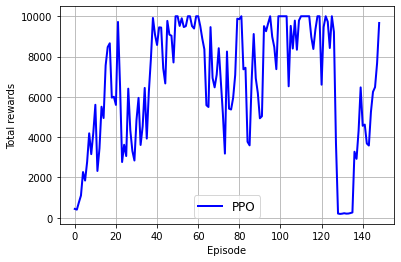

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'PPO')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
#plt.xlim(0, no_of_episodes)
#plt.ylim(0, 20000)
#plt.legend(['Double DQN', 'Dueling DQN', 'D3QN'], loc=4)
plt.grid(True)

In [4]:
# TEST   
episode = 0
s = env.reset()    
h_out = (torch.zeros([1, 1, 32], dtype=torch.float), torch.zeros([1, 1, 32], dtype=torch.float))
h_in = h_out
score = 0
while episode < 3:  # episode loop
    env.render()

    prob, h_out = model.pi(torch.from_numpy(s).float(), h_in)
    prob = prob.view(-1)
    m = Categorical(prob)
    a = m.sample().item()
    s_prime, r, done, info = env.step(a)  # take a random action
    s = s_prime
    h_in = h_out
    sleep(0.01)
    if done:
        env.close()
    score = score + r
    if done:
        episode = episode + 1
        print('Episode: {} Score: {}'.format(episode, score))
        state = env.reset()
env.close()    




Episode: 1 Score: 500.0
Episode: 2 Score: 1000.0
Episode: 3 Score: 1500.0
